In [ ]:
from google.colab import files 

%tensorflow_version 2.x 
import tensorflow as tf 

from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences 
from tensorflow.keras.models import Model 
from tensorflow.keras.layers import Dense, Embedding, GRU 
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.losses import SparseCategoricalCrossentropy 
import numpy as np 


import matplotlib.pyplot as plt 
import matplotlib.ticker as ticker 

from sklearn.model_selection import train_test_split 
import re 
import time 
import os 

# **Загрузка и парсинг данных**

In [ ]:
files.upload() # http://www.manythings.org/anki/

{}

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path_to_file = '/content/drive/MyDrive/Базы/output (2).txt' 

In [ ]:
def preprocess_sentence(phrases): 
    phrases = re.sub(r"([?.!,;:])", r" \1 ", phrases) 
    phrases = re.sub(r"[^a-zA-Zа-яёА-ЯЁ?.!,;:]+", " ", phrases) 

    phrases = phrases.rstrip().strip() 
    phrases = '<start> ' + phrases + ' <end>' 
    return phrases 
print("Фразы после обработки функцией с т.з. пунктуации примут вид:")
print(preprocess_sentence("What about you?"))
print(preprocess_sentence("А как насчет тебя?"))

Фразы после обработки функцией с т.з. пунктуации примут вид:
<start> What about you ? <end>
<start> А как насчет тебя ? <end>


In [ ]:
def create_dataset(path, num_examples): 
    lines = open(path, encoding='UTF-8').read().strip().split('\n')
    word_pairs = [[preprocess_sentence(phrases) for phrases in l.split('\t')]  for l in lines[:num_examples]]
    return zip(*word_pairs) 

print("Взглянем на пример пары фраз на выходе функции:")
english, deutsch = create_dataset(path_to_file, None) 
print(english[-1]) 
print(deutsch[-1]) 

Взглянем на пример пары фраз на выходе функции:
<start> Doubtless there exists in this world precisely the right woman for any given man to marry and vice versa ; but when you consider that a human being has the opportunity of being acquainted with only a few hundred people , and out of the few hundred that there are but a dozen or less whom he knows intimately , and out of the dozen , one or two friends at most , it will easily be seen , when we remember the number of millions who inhabit this world , that probably , since the earth was created , the right man has never yet met the right woman . <end>
<start> Ohne Zweifel findet sich auf dieser Welt zu jedem Mann genau die richtige Ehefrau und umgekehrt ; wenn man jedoch in Betracht zieht , dass ein Mensch nur Gelegenheit hat , mit ein paar hundert anderen bekannt zu sein , von denen ihm nur ein Dutzend oder weniger nahesteht , darunter h chstens ein oder zwei Freunde , dann erahnt man eingedenk der Millionen Einwohner dieser Welt lei

In [ ]:
def max_length(tensor): 
  return max(len(t) for t in tensor) 


def tokenize(language): 
    language_tokenizer = Tokenizer(filters='') 
    language_tokenizer.fit_on_texts(language) 
    tensor = language_tokenizer.texts_to_sequences(language) 
    tensor = pad_sequences(tensor, padding='post') 

    return tensor, language_tokenizer 


def load_dataset(path, num_examples=None): 
    targ_language, inp_language = create_dataset(path, num_examples)

    input_tensor, inp_language_tokenizer = tokenize(inp_language) 
    target_tensor, targ_language_tokenizer = tokenize(targ_language) 

    return input_tensor, target_tensor, inp_language_tokenizer, targ_language_tokenizer

In [ ]:
num_examples = 40000 
input_tensor, target_tensor, inp_language_tokenizer, targ_language_tokenizer = load_dataset(path_to_file, num_examples)

max_length_targ, max_length_inp = max_length(target_tensor), max_length(input_tensor)

input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)


def convert(language, tensor):
    for t in tensor:
        if t!=0:
            print ("%d ----> %s" % (t, language.index_word[t]))
print ("Фраза на немецком языке; соответствие индекса и слова")
convert(inp_language_tokenizer, input_tensor_train[0])
print ()
print ("Фраза на английском языке; соответствие индекса и слова")
convert(targ_language_tokenizer, target_tensor_train[0])
print ()
print("Нем. яз. тренировочная: " , len(input_tensor_train), "фраз; ", "Анг.яз. тренировочная: ", len(target_tensor_train), "фраз")
print("Нем. яз. тестовая: ", len(input_tensor_val), "фраз; ", "Анг.яз. тестовая: ", len(target_tensor_val), "фраз")

Фраза на немецком языке; соответствие индекса и слова
1 ----> <start>
5 ----> tom
6 ----> ist
1735 ----> geschwommen
3 ----> .
2 ----> <end>

Фраза на английском языке; соответствие индекса и слова
1 ----> <start>
5 ----> tom
1269 ----> swam
3 ----> .
2 ----> <end>

Нем. яз. тренировочная:  32000 фраз;  Анг.яз. тренировочная:  32000 фраз
Нем. яз. тестовая:  8000 фраз;  Анг.яз. тестовая:  8000 фраз


# **Параметры нейросети**

In [ ]:
BUFFER_SIZE = len(input_tensor_train) 

BATCH_SIZE = 64 
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE 
embedding_dim = 256 
units = 1024 
vocab_inp_size = len(inp_language_tokenizer.word_index)+1
vocab_tar_size = len(inp_language_tokenizer.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 17]), TensorShape([64, 10]))

# **Создаём классы Encoder, Attention, Decoder**


In [ ]:
class Encoder(Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz): 
        super(Encoder, self).__init__() 
        self.batch_sz = batch_sz 
        self.enc_units = enc_units 
        self.embedding = Embedding(vocab_size, embedding_dim)  
        self.gru = GRU(self.enc_units, return_sequences=True, return_state=True, recurrent_initializer='glorot_uniform')
 
    def call(self, x, hidden): 
        x = self.embedding(x) 
        output, state = self.gru(x, initial_state = hidden) 
        return output, state 

    def initialize_hidden_state(self): 
        return tf.zeros((self.batch_sz, self.enc_units))      

In [ ]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)
sample_hidden = encoder.initialize_hidden_state() 

sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Размеры выхода из кодировщика: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Размеры скрытого состояния: (batch size, units) {}'.format(sample_hidden.shape))

Размеры выхода из кодировщика: (batch size, sequence length, units) (64, 17, 1024)
Размеры скрытого состояния: (batch size, units) (64, 1024)


In [ ]:
class BahdanauAttention(Model): 
    def __init__(self, units): 
        super(BahdanauAttention, self).__init__() 
        self.W1 = Dense(units) 
        self.W2 = Dense(units) 
        self.V =  Dense(1) 

    def call(self, hidden_state, values): 
        hidden_with_time_axis = tf.expand_dims(hidden_state, 1)

        score = self.V(tf.nn.tanh(self.W1(values) + self.W2(hidden_with_time_axis)))
        attention_weights = tf.nn.softmax(score, axis=1)

        context_vector = attention_weights * values 
        context_vector = tf.reduce_sum(context_vector, axis=1) 
        return context_vector, attention_weights 

In [ ]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Размеры значения внимания: (размер батча, размер слоя) {}".format(attention_result.shape))
print("Размеры весов внимания: (размер батча, длина последовательности, 1) {}".format(attention_weights.shape))

Размеры значения внимания: (размер батча, размер слоя) (64, 1024)
Размеры весов внимания: (размер батча, длина последовательности, 1) (64, 17, 1)


In [ ]:

class Decoder(Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__() 
        self.batch_sz = batch_sz 
        self.dec_units = dec_units 
        self.embedding = Embedding(vocab_size, embedding_dim)    
        self.gru = GRU(self.dec_units, return_sequences=True, return_state=True, recurrent_initializer='glorot_uniform')
        self.fc = Dense(vocab_size)

        self.attention = BahdanauAttention(self.dec_units) 

    def call(self, x, hidden, enc_output):
        context_vector, attention_weights = self.attention(hidden, enc_output)
        x = self.embedding(x)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        output, state = self.gru(x)
        output = tf.reshape(output, (-1, output.shape[2]))
        x = self.fc(output) 

        return x, state, attention_weights

In [ ]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)
sample_decoder_output, _, _ = decoder(tf.random.uniform((64, 1)), sample_hidden, sample_output)

print ('Размер выхода с декодера: (размер батча, размер словаря) {}'.format(sample_decoder_output.shape))

Размер выхода с декодера: (размер батча, размер словаря) (64, 8291)


In [ ]:
optimizer = Adam() 
loss_object = SparseCategoricalCrossentropy(from_logits=True, reduction='none') 

def loss_function(real, pred): 
    mask = tf.math.logical_not(tf.math.equal(real, 0)) 
    loss_ = loss_object(real, pred) 

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    
    return tf.reduce_mean(loss_)

# **Обучение Нейросети**


In [ ]:
checkpoint_dir = './training_checkpoints' 
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt") 
checkpoint = tf.train.Checkpoint(optimizer=optimizer, encoder=encoder, decoder=decoder) 

In [ ]:
@tf.function
def train_step(inp, targ, enc_hidden): 
    loss = 0 
    with tf.GradientTape() as tape:
        enc_output, enc_hidden = encoder(inp, enc_hidden)
        dec_hidden = enc_hidden 
        dec_input = tf.expand_dims([targ_language_tokenizer.word_index['<start>']] * BATCH_SIZE, 1)
        for t in range(1, targ.shape[1]): 
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output) 
            loss += loss_function(targ[:, t], predictions)
            dec_input = tf.expand_dims(targ[:, t], 1)
    batch_loss = (loss / int(targ.shape[1])) 
    variables = encoder.trainable_variables + decoder.trainable_variables 
    gradients = tape.gradient(loss, variables) 
    optimizer.apply_gradients(zip(gradients, variables)) 

    return batch_loss 

In [ ]:
EPOCHS = 30

for epoch in range(EPOCHS):
    start = time.time() 
    enc_hidden = encoder.initialize_hidden_state()
    total_loss = 0
    for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
        batch_loss = train_step(inp, targ, enc_hidden) 
        total_loss += batch_loss 

    if (epoch + 1) % 10 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)
    print('Эпоха {} Ошибка {:.4f}'.format(epoch + 1, total_loss / steps_per_epoch))
    print('Время на 1 эпоху {} сек\n'.format(round(time.time() - start), 1))

Эпоха 1 Ошибка 2.0392
Время на 1 эпоху 104 сек

Эпоха 2 Ошибка 1.3641
Время на 1 эпоху 88 сек

Эпоха 3 Ошибка 0.9145
Время на 1 эпоху 88 сек

Эпоха 4 Ошибка 0.5923
Время на 1 эпоху 88 сек

Эпоха 5 Ошибка 0.3889
Время на 1 эпоху 87 сек

Эпоха 6 Ошибка 0.2683
Время на 1 эпоху 88 сек

Эпоха 7 Ошибка 0.1951
Время на 1 эпоху 88 сек

Эпоха 8 Ошибка 0.1477
Время на 1 эпоху 88 сек

Эпоха 9 Ошибка 0.1190
Время на 1 эпоху 88 сек

Эпоха 10 Ошибка 0.1015
Время на 1 эпоху 88 сек

Эпоха 11 Ошибка 0.0896
Время на 1 эпоху 88 сек

Эпоха 12 Ошибка 0.0822
Время на 1 эпоху 88 сек

Эпоха 13 Ошибка 0.0780
Время на 1 эпоху 88 сек

Эпоха 14 Ошибка 0.0762
Время на 1 эпоху 88 сек

Эпоха 15 Ошибка 0.0705
Время на 1 эпоху 88 сек

Эпоха 16 Ошибка 0.0669
Время на 1 эпоху 88 сек

Эпоха 17 Ошибка 0.0659
Время на 1 эпоху 88 сек

Эпоха 18 Ошибка 0.0639
Время на 1 эпоху 88 сек

Эпоха 19 Ошибка 0.0627
Время на 1 эпоху 88 сек

Эпоха 20 Ошибка 0.0601
Время на 1 эпоху 88 сек

Эпоха 21 Ошибка 0.0570
Время на 1 эпоху 88 сек



In [ ]:
def evaluate(sentence):
    attention_plot = np.zeros((max_length_targ, max_length_inp))

    sentence = preprocess_sentence(sentence)

    inputs = [inp_language_tokenizer.word_index[i] for i in sentence.split(' ')]
    inputs = pad_sequences([inputs], maxlen=max_length_inp, padding='post') 
    inputs = tf.convert_to_tensor(inputs)

    result = ''

    hidden = [tf.zeros((1, units))] 
    enc_out, enc_hidden = encoder(inputs, hidden) 
    dec_hidden = enc_hidden 
    dec_input = tf.expand_dims([targ_language_tokenizer.word_index['<start>']], 0) 

    for t in range(max_length_targ): 
        predictions, dec_hidden, attention_weights = decoder(dec_input, dec_hidden, enc_out)
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()
        predicted_id = tf.argmax(predictions[0]).numpy()
        result += targ_language_tokenizer.index_word[predicted_id] + ' '
        if targ_language_tokenizer.index_word[predicted_id] == '<end>':
            return result, sentence, attention_plot
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot

In [ ]:
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [ ]:
def translate(sentence): 
    result, sentence, attention_plot = evaluate(sentence)

    print('Входящая фраза: %s' % (sentence))
    print('Предсказанный перевод: {}'.format(result))

    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Входящая фраза: <start> lass uns freunde sein <end>
Предсказанный перевод: let s be friends . <end> 


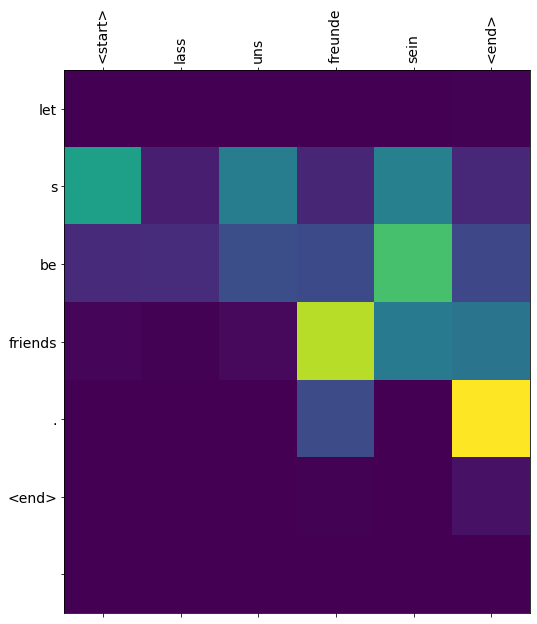

In [ ]:
translate('lass uns Freunde sein'.lower()) # let's be friends

Входящая фраза: <start> geht es dir gut <end>
Предсказанный перевод: go to be ok . <end> 


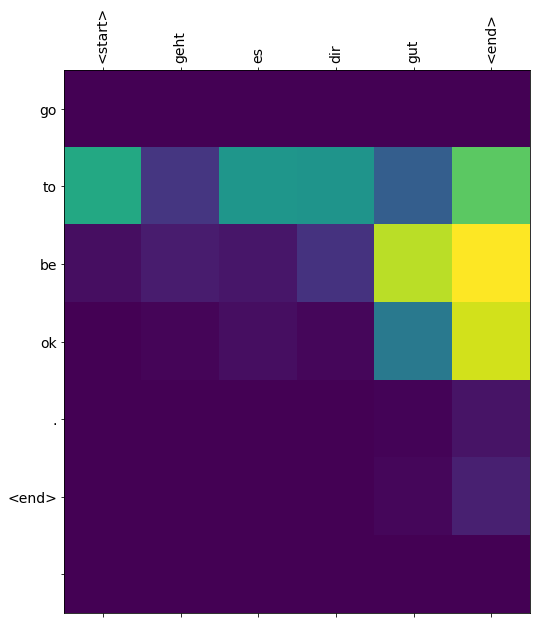

In [ ]:
translate('Geht es dir gut'.lower()) # you are all right

Входящая фраза: <start> geht es dir gut ? <end>
Предсказанный перевод: are you all right ? <end> 


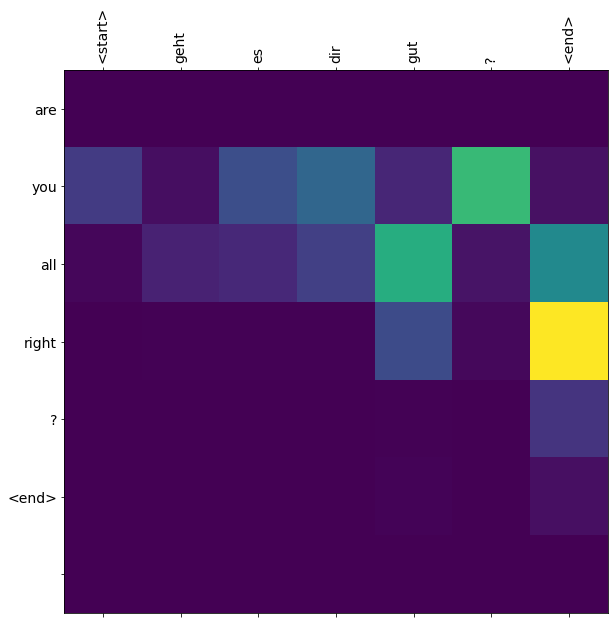

In [ ]:
translate('Geht es dir gut?'.lower()) # are you all right?

Входящая фраза: <start> wann wirst du fertig sein ? <end>
Предсказанный перевод: when will you done ? <end> 


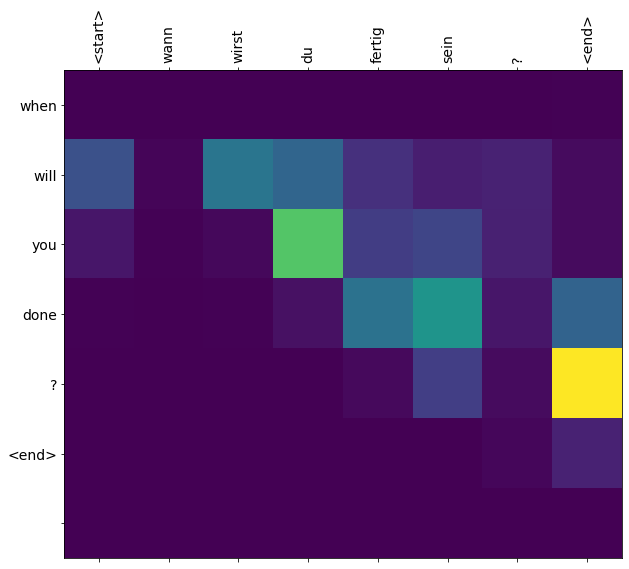

In [ ]:
translate('wann wirst du fertig sein?'.lower())  # when will you be ready ?

Входящая фраза: <start> wie sp t ist es <end>
Предсказанный перевод: what time is it ? <end> 


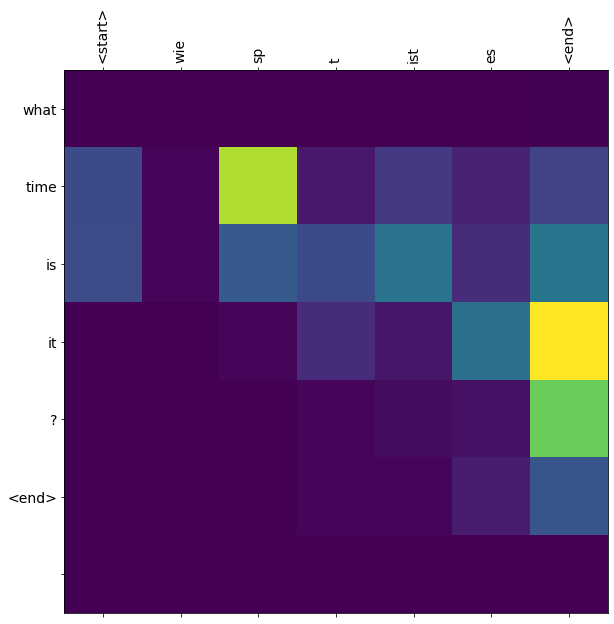

In [ ]:
translate('wie spät ist es'.lower())  # what time is it ?

Входящая фраза: <start> was ist das ? <end>
Предсказанный перевод: what is that ? <end> 


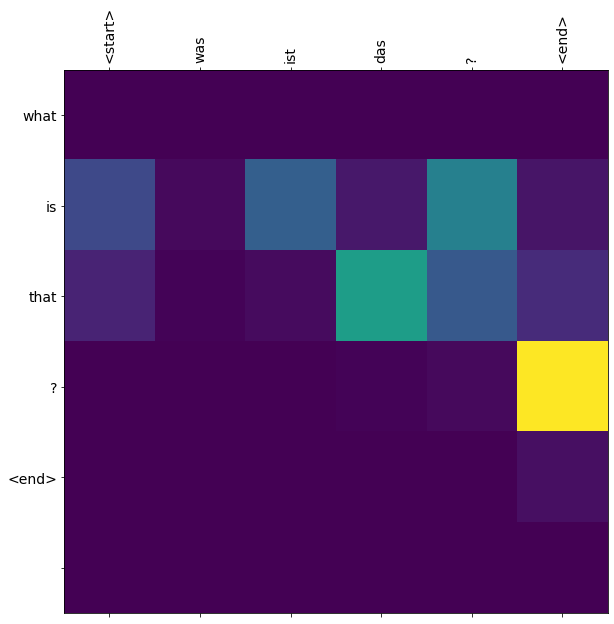

In [ ]:
translate('Was ist das?'.lower())  # what is that?